# **Taller Clasificación de Texto**

### Asignatura PLN
#### Universidad Nacional de Colombia
---


# Taller clasificación de textos - Análisis de sentimientos

El objetivo de este taller es construir clasificadores para el análisis de sentimientos. Se deberán utilizar diferentes representaciones de los documentos y diferentes modelos de aprendizaje maquinal.

Se utilizará el dataset para análisis de sentimientos de [Kaggle](https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech), que busca identificar contenido odioso en tweets.

Este taller, contiene algún código para actividades, pero la mayoría las deben escribir ustedes.

In [1]:
# Importar librerías a usar
import pandas as pd
import numpy as np
import nltk, re, string, spacy, os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import seaborn as sns
np.random.seed(0)

from nltk.corpus import stopwords
from nltk import word_tokenize

In [2]:
# Armar el conjunto de datos
# corpus (datos) y labels (etiquetas)
tweet_df = pd.read_csv("../Files/hate/train.csv", index_col='id')
tweet_df

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...
31960,0,listening to sad songs on a monday morning otw...


## 1. Preprocesamiento


-  Crear una función para preprocesar el corpus, esta función debe dejar todas las palabras en minúscula, eliminar caracteres especiales, separar signos de puntuación y eliminar stopwords.
El conjunto de datos se encuentra en las variables **corpus** y **labels**.


In [3]:
reg = re.compile(r'[A-Za-z\d\.,\'\s-]+')
def preprocessing(doc):
    document = doc.lower()
    document = ' '.join(reg.findall(document))
    tokens = word_tokenize(document)
    tokens = [t for t in tokens if t not in stopwords.words('english')]

    return tokens

norm_corpus = tweet_df.tweet.apply(preprocessing)
norm_corpus

id
1        [user, father, dysfunctional, selfish, drags, ...
2        [user, user, thanks, lyft, credit, ca, n't, us...
3                                        [bihday, majesty]
4                      [model, love, u, take, u, time, ur]
5                        [factsguide, society, motivation]
                               ...                        
31958                              [ate, user, isz, youuu]
31959    [see, nina, turner, airwaves, trying, wrap, ma...
31960    [listening, sad, songs, monday, morning, otw, ...
31961    [user, sikh, temple, vandalised, calgary, ,, w...
31962                                [thank, user, follow]
Name: tweet, Length: 31962, dtype: object

In [4]:
corpus_df = pd.DataFrame( columns=['tokens'])
corpus_df['tokens'] = norm_corpus
corpus_df['text'] = corpus_df['tokens'].apply(' '.join)
corpus_df[['text']]

,text
id,
1,user father dysfunctional selfish drags kids d...
2,user user thanks lyft credit ca n't use cause ...
3,bihday majesty
4,model love u take u time ur
5,factsguide society motivation
...,...
31958,ate user isz youuu
31959,see nina turner airwaves trying wrap mantle ge...
31960,listening sad songs monday morning otw work sad


## 2. Análisis exploratorio de los datos

* Encuentre la proporción de documentos de odio y la proporción de documentos normales.
* Construya una nube de palabras para cada categoría.
* Divida el dataset en un conjunto de entrenamiento (60%) y prueba (40%)
* Discuta los resultados.

In [5]:
# Proporción de los datos

## http://sentiment.nrc.ca/lexicons-for-research/

path = "../Files/EmoLex"
vocab={}
words = set()
for lexicon in os.listdir(path):
    # Se abre cada .txt, se extraen todas las palabras y se eliminan saltos de línea.
    with open(f"{path}/{lexicon}","r") as f:
        feeling = lexicon.split(".")[0]
        vocab[feeling] = [i.strip() for i in f.readlines()]
        words.update(vocab[feeling])

lexicon_df = pd.DataFrame(0, index=words, columns=vocab.keys() )
for feeling, words in vocab.items():
    lexicon_df.at[words, [feeling]] = 1
lexicon_df.sum()

anticipation     839
joy              689
positive        2312
disgust         1058
surprise         534
fear            1476
negative        3324
anger           1247
sadness         1191
trust           1231
dtype: int64

## Unify hate lexicons

In [6]:
hate_feeling = {'disgust', 'fear', 'negative', 'anger', 'sadness'}
hate_lex_df = lexicon_df[hate_feeling]
hate_lex_df = hate_lex_df[ hate_lex_df.sum(axis=1) > 0 ]
hate_lex_df

,fear,sadness,negative,disgust,anger
jaws,1,0,0,0,0
vanity,0,0,1,0,0
flesh,0,0,0,1,0
frustrate,0,1,1,1,1
alienated,0,1,1,0,0
...,...,...,...,...,...
involution,0,0,1,0,1
distaste,0,0,1,1,0
astringent,0,0,1,0,0
bout,0,0,1,0,1


## Unify normal lexicons

In [7]:
normal_feeling = {'anticipation', 'joy', 'positive', 'surprise', 'trust'}
normal_lex_df = lexicon_df[normal_feeling]
normal_lex_df = normal_lex_df[ normal_lex_df.sum(axis=1) > 0 ]
normal_lex_df

,surprise,joy,anticipation,trust,positive
negotiate,0,0,0,1,1
tranquility,0,1,0,1,1
hungry,0,0,1,0,0
sensuous,0,1,0,0,1
justification,0,0,0,0,1
...,...,...,...,...,...
enlightenment,0,1,0,1,1
conversational,0,0,0,0,1
darling,0,1,0,1,1
proper,0,0,0,0,1


In [8]:
def count_sentiments(tokens):
    hate_tokens = [t for t in tokens if t in hate_lex_df.index]
    normal_tokens = [t for t in tokens if t in normal_lex_df.index]
    hate_tokens, normal_tokens = len(hate_tokens), len(normal_tokens)
    
    return pd.Series([hate_tokens, normal_tokens], index=['hate', 'normal'])
        
sentiment_df = corpus_df.tokens.apply(count_sentiments)
sentiment_df = pd.concat([corpus_df, sentiment_df], axis=1)
sentiment_df

,tokens,text,hate,normal
id,,,,
1,"[user, father, dysfunctional, selfish, drags, ...",user father dysfunctional selfish drags kids d...,1,1
2,"[user, user, thanks, lyft, credit, ca, n't, us...",user user thanks lyft credit ca n't use cause ...,0,2
3,"[bihday, majesty]",bihday majesty,0,1
4,"[model, love, u, take, u, time, ur]",model love u take u time ur,0,3
5,"[factsguide, society, motivation]",factsguide society motivation,0,0
...,...,...,...,...
31958,"[ate, user, isz, youuu]",ate user isz youuu,0,0
31959,"[see, nina, turner, airwaves, trying, wrap, ma...",see nina turner airwaves trying wrap mantle ge...,1,2
31960,"[listening, sad, songs, monday, morning, otw, ...",listening sad songs monday morning otw work sad,0,0


In [9]:
sentiment_df['label'] = 0
sentiment_df.label.at[ 
  sentiment_df.hate >= sentiment_df.normal
  & sentiment_df[['normal', 'hate']].sum(axis=1)
] = 1
sentiment_df[['text', 'label']]

,text,label
id,,
1,user father dysfunctional selfish drags kids d...,1
2,user user thanks lyft credit ca n't use cause ...,0
3,bihday majesty,0
4,model love u take u time ur,0
5,factsguide society motivation,1
...,...,...
31958,ate user isz youuu,1
31959,see nina turner airwaves trying wrap mantle ge...,0
31960,listening sad songs monday morning otw work sad,1


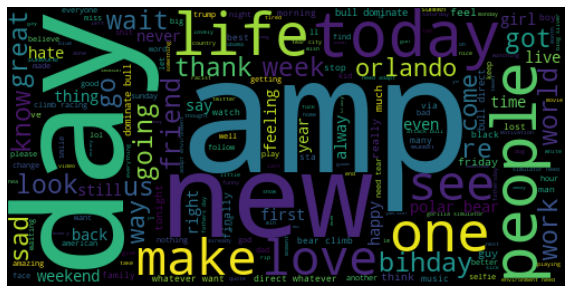

In [10]:
# Nube de palabras Negativas
from wordcloud import WordCloud

text = '\n'.join(corpus_df[sentiment_df.label == 1].text)
text = text.replace('user', '')
text = text.replace('ca', 'can')
text = text.replace("n't", 'not')

wordcloud = WordCloud(width=500, height=250).generate(text)

# Display the generated image:
plt.figure(1, figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

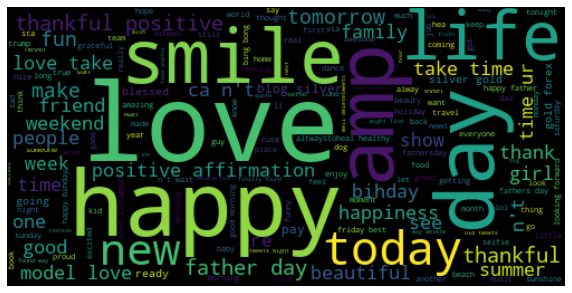

In [11]:
# Nube de palabras Negativas
text = '\n'.join(corpus_df[sentiment_df.label == 0].text)
text = text.replace('user', '')
# text = text.replace('ca', 'can')
# text = text.replace("n't", 'not')

wordcloud = WordCloud(width=500, height=250).generate(text)

# Display the generated image:
plt.figure(1, figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
# Trainign and testing sets

lenght = len(corpus_df)
train_len = int(lenght * 0.6)
train_df = corpus_df.loc[:train_len]
test_df = corpus_df.loc[train_len:]

print(f'''
train dataset: {len(train_df)}
test dataset: {len(test_df)}
''')


train dataset: 19177
test dataset: 12786



In [13]:
# Validación cruzada
test = sentiment_df.loc[test_df.index]
test['real_label'] = tweet_df.loc[test_df.index].label

total_perdictions = len(test['real_label'])
correct_predictions = len(test[test.real_label == test.label])

acuracy = correct_predictions / total_perdictions

print(f'{acuracy * 100:.2f}% de las predicciones fueron correctas.')

51.38% de las predicciones fueron correctas.


## 3. Representación de los textos



1.    
     * Construya una bolsa de palabras para representar los textos.
      
      
2.   * Construya una representación tfidf
3. 
   * Entrene un modelo Word2Vec con el conjunto de entrenamiento.
   * Construya una función que obtenga la representación de un documento como el promedio de sus términos.
   * Construya una función que obtenga la representación de un documento como el promedio de sus 5 palabras más largas.
    

***Nota: si algún documento resulta vacío luego del preprocesamiento, asignele un vector de ceros como representación. Si algún documento tiene menos de 5 palabras, promedie sólo esas palabras.***

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [15]:
# Bolsa de palabras
cv = CountVectorizer()
cv_matrix = cv.fit_transform(train_df.text)

print(cv_matrix.shape)
print(cv_matrix.toarray())

(19177, 28324)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [16]:
# Representación TFIDF

tt = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, sublinear_tf=True)
tt_matrix = tt.fit_transform(train_df.text)

print(tt_matrix.shape)
print(tt_matrix.toarray())

(19177, 28324)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [173]:
# Word2Vec
# from gensim.test.utils import common_texts
from gensim.models import Word2Vec

w2v_model = Word2Vec(train_df.tokens, size=50, window=5, min_count=1, workers=4)
w2v_model

In [174]:
def to_vect(t):
    if t in w2v_model:
        return w2v_model[t]
    return np.zeros(w2v_model.vector_size, dtype=np.float32)
to_vect("@")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [175]:
# Representación word2vec 1
def w2v_repr1(doc_tokenized):
    if len(doc_tokenized) == 0:
        return np.zeros(w2v_model.vector_size, dtype=np.float32)
    
    vectors = np.array([to_vect(t) for t in doc_tokenized])
    return pd.Series(vectors.mean(axis=0))

w2v1_train = train_df.tokens.apply(w2v_repr1).to_numpy()
w2v1_train[0]

array([-0.7263897 ,  0.3942599 , -0.30822864, -0.55480623, -1.2409097 ,
       -0.64275   ,  0.18736224,  0.8291563 , -0.01151122,  0.42090654,
       -0.7529946 , -0.08028955,  0.28277442,  0.01586511, -0.57264304,
        0.6920887 ,  0.345978  ,  0.58627236,  0.11853005,  0.08442168,
       -0.30593932, -0.15204722, -0.22359674,  0.16690212,  0.34577206,
       -0.9937045 , -0.4558399 , -0.0539311 , -0.14304653,  0.7207377 ,
        0.03693726, -0.10433777,  0.688846  , -0.07887033,  2.0183501 ,
        0.09705313,  0.67697483, -0.3574525 ,  0.4796661 ,  1.1142796 ,
        0.08966002, -0.91569585, -0.31665882,  0.69739306,  0.8366206 ,
        0.07895606, -0.38200468, -0.508108  , -0.19544993, -0.36914077],
      dtype=float32)

In [176]:
# Representación word2vec 2
def w2v_repr2(doc_tokenized, n=5):
    tokens = doc_tokenized.copy()
    tokens.sort(key=len, reverse=True)
    return w2v_repr1(tokens[:n])

w2v2_train = train_df.tokens.apply(w2v_repr2).to_numpy()
w2v2_train[0]

array([-0.35943735,  0.28410903, -0.01532459, -0.21680215, -0.44299498,
       -0.23769912,  0.14653768,  0.36698845, -0.12465517, -0.01602948,
       -0.24038474, -0.049431  , -0.03315239, -0.01126492, -0.29867128,
        0.2640066 ,  0.19485492,  0.22560668,  0.00750179,  0.04276644,
       -0.15667254,  0.0313311 , -0.11884495,  0.18218675,  0.12577878,
       -0.3726781 , -0.22521785, -0.09940773,  0.18768916,  0.34117535,
        0.01928458, -0.07071918,  0.5247508 , -0.01939239,  0.7683604 ,
       -0.04648226,  0.11482626, -0.19819099,  0.0014848 ,  0.51174366,
        0.04986695, -0.27824634, -0.06513179,  0.40177697,  0.24666755,
        0.02830269, -0.27396768, -0.12417419, -0.11423943, -0.1821094 ],
      dtype=float32)

In [210]:
# Representación doc2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = train_df[['tokens']].apply(lambda doc: TaggedDocument(doc[0], [doc.name]), axis=1)
model_d2v = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4)

d2v_train = (train_df
  .apply(lambda doc: model_d2v[doc.name], axis=1)
  .apply(pd.Series)
  .to_numpy()
)
d2v_train.shape

(19177, 50)

## 4. Clasificación

Entrene un modelo Naive bayes para cada una de las representaciones usando el corpus de datos.

***Nota: tenga cuidado con la selección de la función de verosimilitud: multinomial o Gaussian***

In [21]:
train_Y = tweet_df.loc[train_df.index].label
test_Y = tweet_df.loc[test_df.index].label

In [22]:
# Modelo para la bolsa de palabras
from sklearn.naive_bayes import MultinomialNB

nb_bow = MultinomialNB()
nb_bow.fit(cv_matrix, train_Y)

X_test = cv.transform(test_df.text)

print(f'{nb_bow.score(X_test, test_Y)*100:.2f}% de acuracy parra Naive Bayes con Bag of Words')

95.49% de acuracy parra Naive Bayes con Bag of Words


In [23]:
# Modelo para tfidf
nb_tt = MultinomialNB()
nb_tt.fit(tt_matrix, train_Y)

X_test = cv.transform(test_df.text)

print(f'{nb_tt.score(X_test, test_Y)*100:.2f}% de acuracy parra Naive Bayes')

94.35% de acuracy parra Naive Bayes


In [24]:
# Modelo para la primer representación word2vec
from sklearn.naive_bayes import GaussianNB

gnb_v1 = GaussianNB()
gnb_v1.fit(w2v1_train, train_Y)

X_test = test_df.tokens.apply(w2v_repr1).to_numpy()

print(f'{gnb_v1.score(X_test, test_Y) * 100:.2f}% de acuracy para Naive Bayes con Word2Vec representación 1')

45.07% de acuracy para Naive Bayes con Word2Vec representación 1


In [25]:
# Modelo para la segunda representación word2vec
gnb_v2 = GaussianNB()
gnb_v2.fit(w2v2_train, train_Y)

X_test = test_df.tokens.apply(w2v_repr2).to_numpy()

print(f'{gnb_v2.score(X_test, test_Y) * 100:.2f}% de acuracy para Naive Bayes con Word2Vec representación 2')

44.92% de acuracy para Naive Bayes con Word2Vec representación 2


In [195]:
d2v_train.shape

(19177,)

In [211]:
# Modelo para gnism doc2vec
gnb_d2v = GaussianNB()
gnb_d2v.fit(d2v_train, train_Y)

X_test = (test_df.tokens
  .apply(model_d2v.infer_vector)
  .apply(pd.Series)
  .to_numpy()
)

print(f'{gnb_d2v.score(X_test, test_Y) * 100:.2f}% de acuracy para Naive Bayes con Doc2Vec')

66.33% de acuracy para Naive Bayes con Doc2Vec


## 5. Validación

* Evalúe el desempeño de los tres modelos por medio de métricas como accuracy, precision, f1 y recall.
* Visualice la matríz de confusión.
* Discuta los resultados, ¿hay diferencia entre un promedio total y un promedio con las 10 palabras más largas?.

In [97]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, plot_confusion_matrix


Acuracy:	0.9548725168152667
Percision:	0.8510204081632653
F1:		0.591070163004961
Recall:		0.4527687296416938

Matriz de confucion:



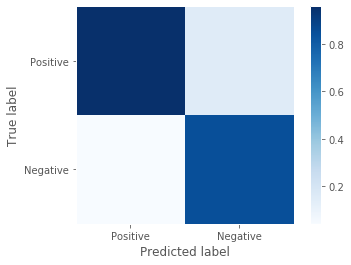

In [123]:
# Evaluación del modelo de bolsa de palabras
X_test = cv.transform(test_df.text)

prerdict_Y = nb_bow.predict(X_test)

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion:
''')
plot_confusion_matrix(
    nb_bow, 
    X_test, 
    test_Y, 
    display_labels=['Positive', 'Negative'],
    normalize='pred',
    include_values=False,
    cmap=plt.cm.Blues,
)
plt.grid(False)
plt.show()


Acuracy:	0.9375097763178476
Percision:	1.0
F1:		0.2339405560882071
Recall:		0.13246471226927253

Matriz de confucion



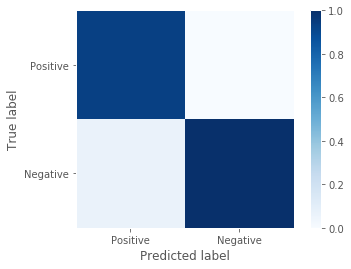

In [126]:
# Evaluación del modelo de tfifd
X_test = tt.transform(test_df.text)

prerdict_Y = nb_tt.predict(X_test)

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion
''')
plot_confusion_matrix(
    nb_tt, 
    X_test, 
    test_Y, 
    display_labels=['Positive', 'Negative'],
    normalize='pred',
    include_values=False,
    cmap=plt.cm.Blues,
)
plt.grid(False)
plt.show()

In [29]:
prerdict_Y.shape

(12786,)


Acuracy:	0.45072735804786485
Percision:	0.09770569620253164
F1:		0.17425044091710756
Recall:		0.8045602605863192

Matriz de confucion:



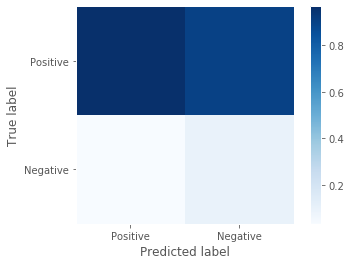

In [127]:
# Evaluación del primer modelo word2vec
X_test = test_df.tokens.apply(w2v_repr1).to_numpy()

prerdict_Y = gnb_v1.predict(X_test)

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion:
''')
plot_confusion_matrix(
    gnb_v1, 
    X_test, 
    test_Y, 
    display_labels=['Positive', 'Negative'],
    normalize='pred',
    include_values=False,
    cmap=plt.cm.Blues,
)
plt.grid(False)
plt.show()


Acuracy:	0.6147348662599719
Percision:	0.10634951838018479
F1:		0.1800932090545939
Recall:		0.5874049945711184

Matriz de confucion:



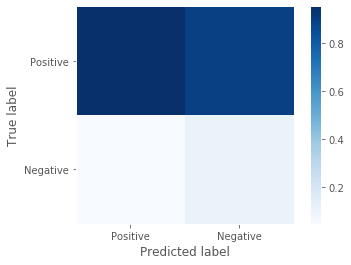

In [206]:
# Evaluación del segundo modelo word2vec
X_test = test_df.tokens.apply(w2v_repr2).to_numpy()

prerdict_Y = gnb_v2.predict(X_test)

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion:
''')
plot_confusion_matrix(
    gnb_v2, 
    X_test, 
    test_Y, 
    display_labels=['Positive', 'Negative'],
    normalize='pred',
    include_values=False,
    cmap=plt.cm.Blues,
)
plt.grid(False)
plt.show()


Acuracy:	0.6559518223056467
Percision:	0.10151237396883593
F1:		0.16764427625354777
Recall:		0.4809989142236699

Matriz de confucion:



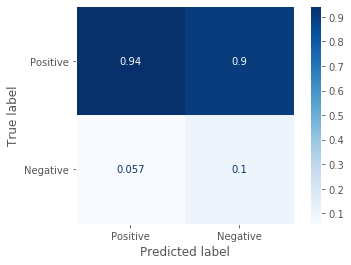

In [212]:
# Evaluación del segundo modelo doc2vec
X_test = (test_df.tokens
  .apply(model_d2v.infer_vector)
  .apply(pd.Series)
  .to_numpy()
)

prerdict_Y = gnb_d2v.predict(X_test)

print(f'''
Acuracy:\t{accuracy_score(test_Y, prerdict_Y)}
Percision:\t{precision_score(test_Y, prerdict_Y)}
F1:\t\t{f1_score(test_Y, prerdict_Y)}
Recall:\t\t{recall_score(test_Y, prerdict_Y)}

Matriz de confucion:
''')
plot_confusion_matrix(
    gnb_d2v, 
    X_test, 
    test_Y, 
    display_labels=['Positive', 'Negative'],
    normalize='pred',
    cmap=plt.cm.Blues,
)
plt.grid(False)
plt.show()

# 6. Aplicación
Utilice el API de twitter para descargar 100 tweets de cada uno de los siguientes temas: "Donald Trump", "Feminism", "Soccer".
Utilice la función de preprocesamiento para limpiar estos tweets.
Seleccione el modelo con el mejor f1 score y utilicelo para predecir estos tweets.
¿Encontró contenido de odio?, discuta los resultados.


In [214]:
# Construcción del corpus
import tweepy, itertools

consumer_key = 'XXXXX'
consumer_secret = 'XXXXXXX'
access_token = 'XXXXXXX'
access_token_secret = 'XXXXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

api.me().name

'Juan Carlos'

In [255]:
cursor_1 = tweepy.Cursor(api.search, 'Donald Trump -filter:retweets', lang='en', tweet_mode='extended').items(100)
cursor_2 = tweepy.Cursor(api.search, 'Feminism -filter:retweets', lang='en', tweet_mode='extended').items(100)
cursor_3 = tweepy.Cursor(api.search, 'Soccer -filter:retweets', lang='en', tweet_mode='extended').items(100)

tweets = itertools.chain(cursor_1, cursor_2, cursor_3)
tweets

In [256]:
def extract_text(tweet):
    full_text = tweet.full_text
    if 'retweeted_status' in dir(a):
        full_text = tweet.retweeted_status.full_text
    return full_text

tweet_text = (extract_text(t) for t in tweets)
tweet_text = pd.Series(tweet_text, name='text')
tweet_text

0      Hydroxychloroquine (HCQ) and chloroquine (CQ) ...
1      Making Waves for Trump: Boaters sail the Gulf ...
2      i might vote for donald trump music video has ...
3      Trump visits one of his private golf courses f...
4      @DonaldJTrumpJr @JohnJamesMI Anybody can vote ...
                             ...                        
295    @PlayoffMarkelle @CullerSports Yessir I rememb...
296                             @glossvm soccer for sure
297    This is just so wrong on every level. No one s...
298    Coronavirus: La Liga to resume from June 8\n.\...
299    Play with @DeadPresPicks for soccer will be po...
Name: text, Length: 300, dtype: object

In [257]:
# preprocesamiento

norm_corpus = tweet_text.apply(preprocessing).apply(' '.join)
norm_corpus

0      hydroxychloroquine hcq chloroquine cq old medi...
1      making waves trump boaters sail gulf show supp...
2      might vote donald trump music video aged like ...
3      trump visits one private golf courses first ti...
4      donaldjtrumpjr johnjamesmi anybody vote anybod...
                             ...                        
295    playoffmarkelle cullersports yessir remember e...
296                                  glossvm soccer sure
297    wrong every level . one grow subject racist ta...
298    coronavirus la liga resume june 8 . . . corona...
299    play deadprespicks soccer posted tomorrow morn...
Name: text, Length: 300, dtype: object

In [258]:
# Representación de modelo con mejor f1
bow_rep = cv.transform(norm_corpus)
predictions = nb_bow.predict(bow_rep)
test_tweet_df = pd.DataFrame({
    'text': norm_corpus,
    'prediction': predictions
})
test_tweet_df

,text,prediction
0,hydroxychloroquine hcq chloroquine cq old medi...,0
1,making waves trump boaters sail gulf show supp...,0
2,might vote donald trump music video aged like ...,0
3,trump visits one private golf courses first ti...,0
4,donaldjtrumpjr johnjamesmi anybody vote anybod...,0
...,...,...
295,playoffmarkelle cullersports yessir remember e...,0
296,glossvm soccer sure,0
297,wrong every level . one grow subject racist ta...,0
298,coronavirus la liga resume june 8 . . . corona...,0


In [260]:
# Ejemplo de contenido de odio

test_tweet_df[ 
    test_tweet_df.prediction == 1
].text.to_list()[:10]

["trump n't care 97,414 dead americans instead brags ratings , job 's scapegoating opponents amp killing americans reopening economy crashed even americans continue die https t.co qnqiwwrwda via huffpostpol https t.co gz6xe8fbmq",
 'chieflizwarren menvoters dogsbcool algrenq jdw714 yespistliberty drtybrd2020 downrangechaos patriqt 1776 lovestr50361283 cdnshade jdd2169 instinctnaturel lisanicholo notmattrellen adrenochromed spaceforcebravo boodacat2020 mrfly187 miss simone247 black back5 sonadorliveson frankdoolin thumper5465 rightinca shrekthepunk supportthecons1 bourbon gal 1quetzalcoatl1 dianneb81797249 julz jailed jillaynemc mhelsley01 vickie627 jonathanhgruber katcourt78664 aarontflint1 magagirl4lyf simon r katz mcgruff2020 rob68326533 weazry karabear110 lor blueeyes 42gnome lou bruette mylakelady backwards247 trumpsugar hurrnot shows trump company long history discrimination . nothing new 1973. donald learned father , usually , also arrested kkk rally',
 "trump 's hydroxychloroqui

In [261]:
# Ejemplo contenido normal
test_tweet_df[ 
    test_tweet_df.prediction == 0
].text.to_list()[:10]

['hydroxychloroquine hcq chloroquine cq old medicines news recurrently since donald trump said publicly march 19 press conference hcq could game changer treatment covid-19 . https t.co bnnp48262j',
 'making waves trump boaters sail gulf show support president donald trump . never seen movement like humbled alive witness trump 2020 pence . https t.co 6olqwrhkzx',
 'might vote donald trump music video aged like wine',
 'trump visits one private golf courses first time 75 days https t.co uo5ahwzvpd via nbcnews',
 "donaldjtrumpjr johnjamesmi anybody vote anybody want . n't make donald j. trump less racist , vote . used phrase good bloodlines three days ago . 's birther . 's sexual assaulter",
 "family values trump 's children key re-election campaign https t.co f9yngg6nrk",
 "whitehouse realdonaldtrump nasa spacex oh shooting rockets want go . 's free taxpayers pick tab everything . - donald trump",
 "karaswisher gtconway3d jack jack n't care . twitter n't care . tos n't apply donald trump